## Analysis for glutamate imaging

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from utils_swim import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, spearmanr
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

### Gain Adaption

In [2]:
from pathlib import Path
from skimage.io import imread
from glob import glob

In [3]:
rootDir = '/mnt/Dali/Takashi/Cezanne/SPIM_newPC/'
folder = '04102019'
fish = 'Fish1-4'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/GABAData/'
dir_folder = Path(dat_folder)
# swim(folder, fish, rootDir, dat_folder)
# trial_swim_power(folder, fish, dir_folder)
# frame_swim_power(folder, fish, dir_folder)
# frame_swim_power_series(folder, fish, dir_folder)

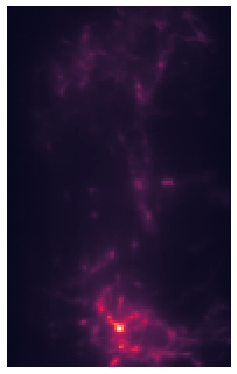

SpearmanrResult(correlation=0.2652916073968705, pvalue=0.11253461250288342)
SpearmanrResult(correlation=0.46181753356771355, pvalue=1.696806854832783e-06)


SpearmanrResult(correlation=0.5862647546580821, pvalue=7.983466725336855e-14)

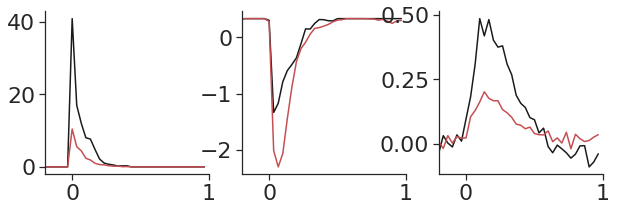

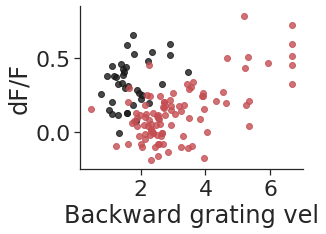

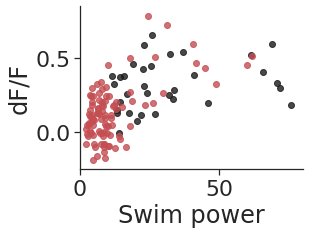

In [4]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
img_dir = rootDir+f'{folder}/{fish}/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]


# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0)

plt.figure(figsize=(4, 10))
plt.imshow(ave)
plt.axis('off')
plt.show()

mask_ = ave>150
ave = ave.reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]
dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = np.ones(pswim_.shape[0]).astype('bool')
    valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
    # valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()
color_list = ['k', 'r', 'b']
for n in range(2):
    ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
    ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
    ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
    sns.despine()
ax[0].set_xlim([-0.2, 1.0])
ax[1].set_xlim([-0.2, 1.0])
ax[2].set_xlim([-0.2, 1.0])
# plt.savefig('../Plots/gaba/example_fish.svg')

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    v_ = -(vis_list[n][:, :].min(axis=-1))
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(v_)
    tmp2.append(d_)
    plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
    print(spearmanr(v_, d_))
plt.xlabel('Backward grating vel')
plt.ylabel('dF/F')
plt.xticks(np.arange(2, 8, 2))
# plt.legend()
sns.despine()
# plt.savefig('../Plots/gaba/example_fish_vel_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    p_ = pswim_list[n][:, :].max(axis=-1)
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(p_)
    tmp2.append(d_)
    plt.scatter(p_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
plt.xlabel('Swim power')
plt.ylabel('dF/F')
plt.xlim([0, 80])
# plt.legend()
sns.despine()
# plt.savefig('../Plots/gaba/example_fish_power_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

### Random Delay

In [5]:
folder = '05012019'
fish = 'Fish1-1-RandomDelay'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/GABAData/'
dir_folder = Path(dat_folder)
# swim(folder, fish, rootDir, dat_folder)
# trial_swim_power(folder, fish, dir_folder)
# frame_swim_power(folder, fish, dir_folder)
# frame_swim_power_series(folder, fish, dir_folder)

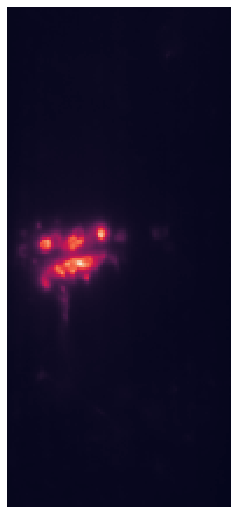

SpearmanrResult(correlation=nan, pvalue=nan)
SpearmanrResult(correlation=0.7999999999999999, pvalue=0.10408803866182788)


SpearmanrResult(correlation=0.6571428571428573, pvalue=0.15617492711370237)

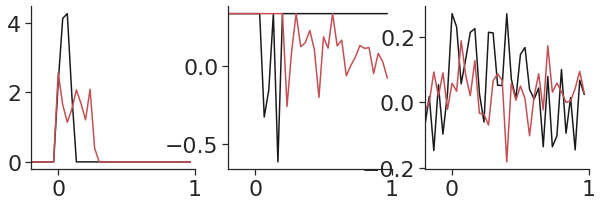

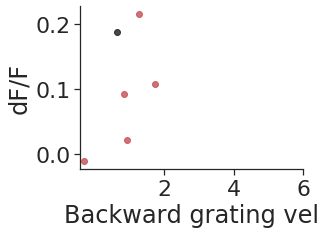

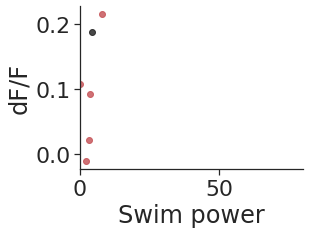

In [6]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
img_dir = rootDir+f'{folder}/{fish}/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]


# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0)

plt.figure(figsize=(4, 10))
plt.imshow(ave)
plt.axis('off')
plt.show()

mask_ = ave>150
ave = ave.reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]
dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = np.ones(pswim_.shape[0]).astype('bool')
    valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
    # valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()
color_list = ['k', 'r', 'b']
for n in range(2):
    ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
    ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
    ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
    sns.despine()
ax[0].set_xlim([-0.2, 1.0])
ax[1].set_xlim([-0.2, 1.0])
ax[2].set_xlim([-0.2, 1.0])
# plt.savefig('../Plots/gaba/example_fish.svg')

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    v_ = -(vis_list[n][:, :].min(axis=-1))
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(v_)
    tmp2.append(d_)
    plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
    print(spearmanr(v_, d_))
plt.xlabel('Backward grating vel')
plt.ylabel('dF/F')
plt.xticks(np.arange(2, 8, 2))
# plt.legend()
sns.despine()
# plt.savefig('../Plots/gaba/example_fish_vel_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    p_ = pswim_list[n][:, :].max(axis=-1)
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(p_)
    tmp2.append(d_)
    plt.scatter(p_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
plt.xlabel('Swim power')
plt.ylabel('dF/F')
plt.xlim([0, 80])
# plt.legend()
sns.despine()
# plt.savefig('../Plots/gaba/example_fish_power_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

### Random Gain

In [7]:
folder = '05012019'
fish = 'Fish1-2-RandomGain'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/GABAData/'
dir_folder = Path(dat_folder)
# swim(folder, fish, rootDir, dat_folder)
# trial_swim_power(folder, fish, dir_folder)
# frame_swim_power(folder, fish, dir_folder)
# frame_swim_power_series(folder, fish, dir_folder)

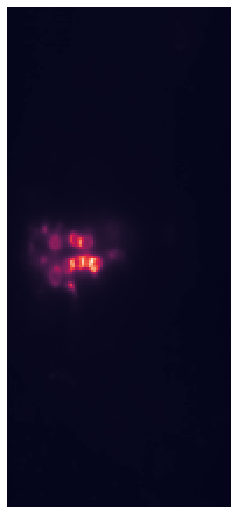

SpearmanrResult(correlation=1.0, pvalue=0.0)
SpearmanrResult(correlation=-1.0, pvalue=0.0)


SpearmanrResult(correlation=0.2571428571428572, pvalue=0.6227871720116618)

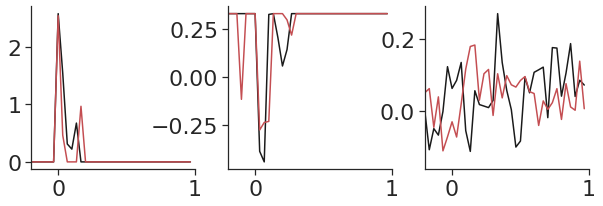

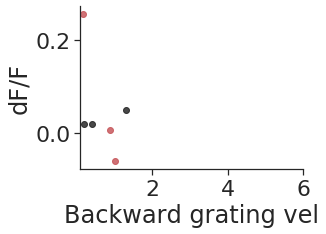

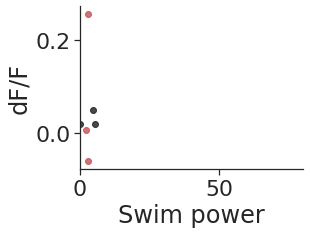

In [8]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
img_dir = rootDir+f'{folder}/{fish}/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]


# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0)

plt.figure(figsize=(4, 10))
plt.imshow(ave)
plt.axis('off')
plt.show()

mask_ = ave>150
ave = ave.reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]
dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = np.ones(pswim_.shape[0]).astype('bool')
    valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
    # valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()
color_list = ['k', 'r', 'b']
for n in range(2):
    ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
    ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
    ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
    sns.despine()
ax[0].set_xlim([-0.2, 1.0])
ax[1].set_xlim([-0.2, 1.0])
ax[2].set_xlim([-0.2, 1.0])
# plt.savefig('../Plots/gaba/example_fish.svg')

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    v_ = -(vis_list[n][:, :].min(axis=-1))
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(v_)
    tmp2.append(d_)
    plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
    print(spearmanr(v_, d_))
plt.xlabel('Backward grating vel')
plt.ylabel('dF/F')
plt.xticks(np.arange(2, 8, 2))
# plt.legend()
sns.despine()
# plt.savefig('../Plots/gaba/example_fish_vel_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

tmp1 = []
tmp2 = []
plt.figure(figsize=(4, 3))
for n in range(2):
    ave_dff = dff_list[n].mean(axis=-1)*100
    p_ = pswim_list[n][:, :].max(axis=-1)
    d_ = ave_dff[:, t_pre+0:t_pre+6].mean(axis=-1)
    tmp1.append(p_)
    tmp2.append(d_)
    plt.scatter(p_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
plt.xlabel('Swim power')
plt.ylabel('dF/F')
plt.xlim([0, 80])
# plt.legend()
sns.despine()
# plt.savefig('../Plots/gaba/example_fish_power_act.svg')
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))